# 3D mesh builder

This tutorial demonstrates how to use the `qdyn.compute_mesh_coords` routine to build custom fault meshes in 3D. Even though a geometrically simple fault can already exhibit complex and interesting rupture behaviour, it is sometimes useful to include additional geometric complexities (for instance to mimic real-world fault networks). Before continuing, it is important to take note of a major assumption that prevents arbitrary fault geometries in QDYN; to speed up the computations, stress kernel convolution operation is replaced by a multiplication in the spectral domain in the along-strike direction. This means that the fault mesh must be Euclidean (evenly spaced and co-linear) in the along-strike direction, and that the number of elements must be an integer power of 2 and constant across the mesh. 

With this limitation in mind, it is still possible to introduce fault complexity in the along-dip direction. In this example, we will create two separate faults that are geometrically distinct. This is done by first creating a uniform mesh that is subsequently modified, before writing the `qdyn.in` input file. The results of the simulation are visualised with a 3D animation.

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.signal.windows import cosine

from qdyn import qdyn

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year
L = 5e3                     # Length of fault along-strike
W = 6e3                     # Length of fault along-dip
resolution = 5              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 2        # Simulation dimensionality (2D fault in 3D medium)
set_dict["FAULT_TYPE"] = 2     # Thrust fault
set_dict["TMAX"] = 1*t_yr      # Maximum simulation time [s]
set_dict["NTOUT_OX"] = 20         # Save output every N steps
set_dict["NXOUT_OX"] = 1          # Snapshot resolution along-strike (every N elements)
set_dict["NWOUT_OX"] = 1          # Snapshot resolution along-dip (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 1e7        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)
set_dict["Z_CORNER"] = -1e4    # Base of the fault (depth taken <0)
set_dict["DIP_W"] = 80         # Dip of the fault

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.2e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1.0e-2    # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 1e-3     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"]     # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = 0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]

# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / ((set_dict["SET_DICT_RSF"]["B"] - set_dict["SET_DICT_RSF"]["A"]) * set_dict["SIGMA"])

print(f"Process zone size: {Lb} m \t Nucleation length: {Lc} m")

# Find next power of two for number of mesh elements along-strike
Nx = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Along-dip direction doesn't need to be a power of 2
Nw = int(resolution * W / Lb)

# Set mesh size and fault length
set_dict["NX"] = Nx
set_dict["NW"] = Nw
set_dict["L"] = L
set_dict["W"] = W
# Set time series output node to the middle of the fault
set_dict["IC"] = Nx * (Nw // 2) + Nx // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

Process zone size: 300.0 m 	 Nucleation length: 375.0 m


True

After generating the default mesh with `p.render_mesh()`, we will define a new (non-uniform) vector with variable fault dip and element spacing, and update the mesh with `p.compute_mesh_coords`. Having variable element spacing (in the along-dip direction) can be useful to have finer outputs on one particular fault, or close to an asperity.

**Note**: currently the mesh is built starting from the base of the fault going up (towards the free surface). The first element in the mesh is therefore located at the bottom of the fault.

In [3]:
split = Nw // 3  # Cut the mesh as this location

# Create a vector of dip values for the mesh
dip = np.ones(Nw) * set_dict["DIP_W"]
dip[:split] = 0.5 * set_dict["DIP_W"]

# Create a vector of mesh element spacings
dw = np.ones(Nw) * (W / Nw)
dw[split:] = 0.5 * (W / Nw)

# Override the default mesh with these new dip/spacing values
p.compute_mesh_coords(p.mesh_dict, dip, dw)

Secondly, we can also decide to modify the frictional parameters on each fault, and to create an offset between the faults (in this example the fault is offset along the x-coordinate).

In [4]:
# Get the mesh b-values
b = p.mesh_dict["B"].reshape((Nw, Nx))

# Define tapers to let the b-value go to zeroes at the edges of each fault
taper1 = np.outer(cosine(split), cosine(Nx))
taper2 = np.outer(cosine(Nw-split), cosine(Nx))

# Apply the tapers to each fault
b[:split] *= taper1
b[split:] *= taper2

# Override the default mesh values
p.mesh_dict["B"] = b.ravel()


# Get the mesh x-coordinate values
X = p.mesh_dict["X"].reshape((Nw, Nx))

# Apply a constant offset for each element on the first fault
dX = 3e3
X[:split] += dX

# Override the mesh coordinates
p.mesh_dict["X"] = X.ravel()

# Write input to qdyn.in
p.write_input()

True

We can visualise the mesh in a Cartesian coordinate frame using `matplotlib.plot_surface`. For example, we can plot the distribution of $(a-b)$ and the value of the along-dip mesh spacing.

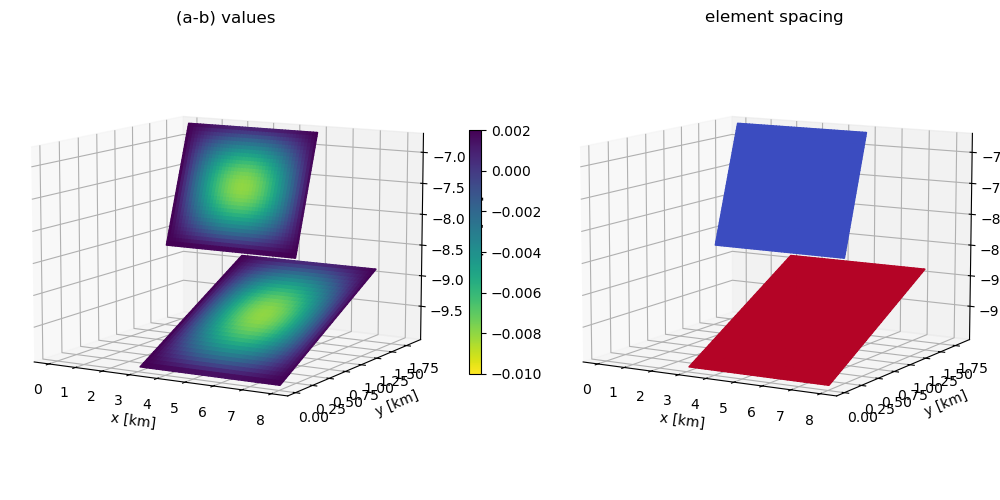

In [5]:
# Get the mesh values and reshape them into matrices
x = p.mesh_dict["X"].reshape((Nw, Nx)) * 1e-3
y = p.mesh_dict["Y"].reshape((Nw, Nx)) * 1e-3
z = p.mesh_dict["Z"].reshape((Nw, Nx)) * 1e-3
aminb = (p.mesh_dict["A"] - p.mesh_dict["B"]).reshape((Nw, Nx))
dw = p.mesh_dict["DW"].reshape((Nw, Nx))

# Define colour scales for (a-b) and mesh spacing
norm = cm.colors.Normalize(vmin=-1e-2, vmax=2e-3)
cmap = cm.viridis_r

norm2 = cm.colors.Normalize(vmin=dw.min(), vmax=dw.max())
cmap2 = cm.coolwarm

plt.close("all")
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True, subplot_kw={"projection": "3d"})

# Plot (a-b)
ax = axes[0]
CS = ax.plot_surface(x[:split], y[:split], z[:split], facecolors=cmap(norm(aminb[:split])), antialiased=True, shade=False)
ax.plot_surface(x[split:], y[split:], z[split:], facecolors=cmap(norm(aminb[split:])), antialiased=True, shade=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)
ax.set_title("(a-b) values")

# Plot mesh spacing (note that this is a binary distribution)
ax = axes[1]
ax.plot_surface(x[:split], y[:split], z[:split], facecolors=cmap2(norm2(dw[:split])), antialiased=True, shade=False)
ax.plot_surface(x[split:], y[split:], z[split:], facecolors=cmap2(norm2(dw[split:])), antialiased=True, shade=False)
ax.set_title("element spacing")

# Decorate axes and set initial viewing angles
for ax in axes:
    ax.set_xlabel("x [km]")
    ax.set_ylabel("y [km]")
    ax.set_zlabel("depth [km]")
    ax.view_init(elev=10, azim=-60)

plt.show()

In [6]:
# Run the simulation
p.run()

# Read the simulation output
p.read_output()

/mnt/Pollux/QDYN/qdyn/qdyn/pyqdyn.py:792: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = read_csv(
/mnt/Pollux/QDYN/qdyn/qdyn/pyqdyn.py:808: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.ot_vmax = read_csv(
/mnt/Pollux/QDYN/qdyn/qdyn/pyqdyn.py:828: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_ox = read_csv(filename_ox, header=None, names=quants_ox, delim_whitespace=True, comment="#")


True

The output of 3D simulations is structured in the same dataframes as for the other simulation types. We can check the maximum slip rate evolution with `p.ot_vmax["v"]`:

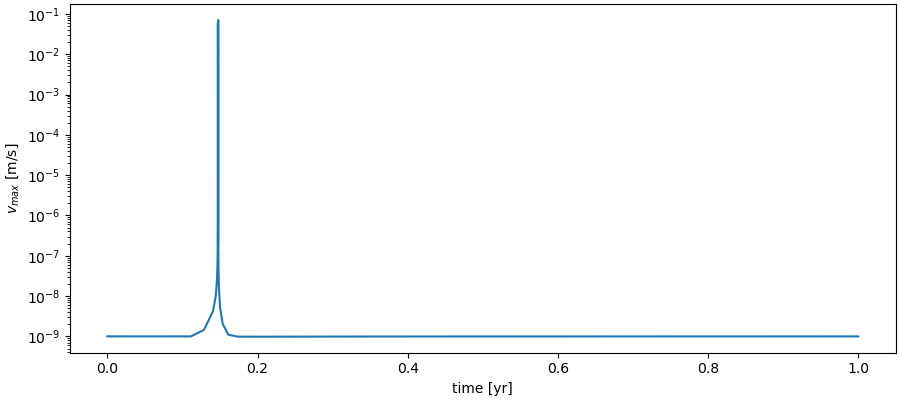

In [7]:
plt.close("all")
fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(p.ot_vmax["t"] / t_yr, p.ot_vmax["v"])
ax.set_yscale("log")
ax.set_ylabel(r"$v_{max}$ [m/s]")
ax.set_xlabel("time [yr]")
plt.show()

The last element of this tutorial is to visualise the snapshots in an animated 3D surface plot. Note that saving the animation requires the `ffmpeg` library to be installed (`conda install ffmpeg`).

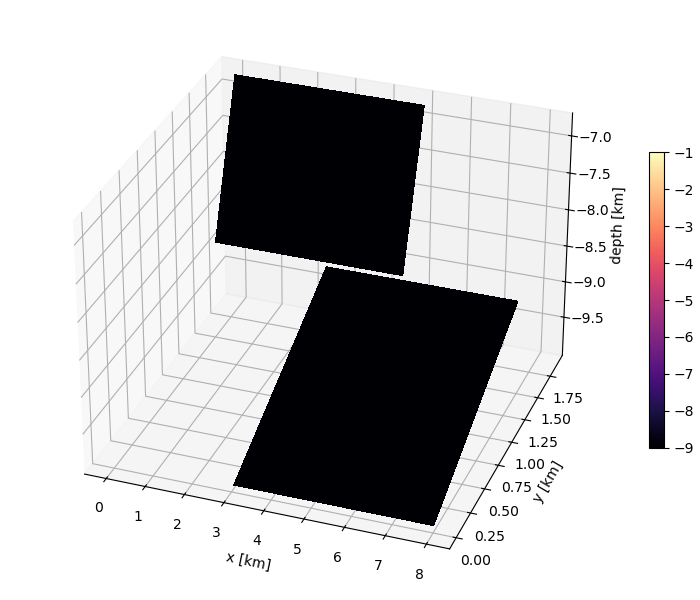

In [8]:
from matplotlib import animation

# Plotting parameters
surface_kwargs = {
    "linewidth": 0,
    "antialiased": False,
    "shade": False,
}


# Select a time interval
t_vals = np.sort(p.ox["t"].unique())
# inds = t_vals > 0.0 * t_yr
inds = t_vals < 0.2 * t_yr
t_vals = t_vals[inds]

# Initial snapshot
inds = (p.ox["t"] == p.ox["t"].min())

# Output was created every dN elements
dNw = set_dict["NWOUT_OX"]
dNx = set_dict["NXOUT_OX"]

Nx_out = int(np.ceil(Nx / dNx))
Nw_out = int(np.ceil(Nw / dNw))

# Select x/y/z and slip rate (v)
x = p.ox["x"][inds].values.reshape((Nw_out, Nx_out)) * 1e-3
y = p.ox["y"][inds].values.reshape((Nw_out, Nx_out)) * 1e-3
z = p.ox["z"][inds].values.reshape((Nw_out, Nx_out)) * 1e-3
v = np.log10(p.ox["v"][inds].values.reshape((Nw_out, Nx_out)))

# Colour scale normalisation
norm = cm.colors.Normalize(vmin=-9, vmax=-1)
cmap = cm.magma

# Location of our mesh split
split_out = Nw_out // 3

# Frames per second of the animation
fps = 20


# Draw canvas
plt.close("all")
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True, subplot_kw={"projection": "3d"})

# Decorate axes
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("depth [km]")

# Set initial viewing angle
ax.view_init(elev=30, azim=-70)

# Plot first snapshot
CS = ax.plot_surface(x[:split_out], y[:split_out], z[:split_out], facecolors=cmap(norm(v[:split_out])), **surface_kwargs)
CS2 = ax.plot_surface(x[split_out:], y[split_out:], z[split_out:], facecolors=cmap(norm(v[split_out:])), **surface_kwargs)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)

# Collect figure elements
plots = [CS, CS2]

def update(n, plots):
    """ Routine to update figure elements """
    
    # Select time interval
    inds = p.ox["t"] == t_vals[n]
    # Select corresponding slip rate values
    v = np.log10(p.ox["v"][inds].values.reshape((Nw_out, Nx_out)))

    # Remove previous snapshot
    plots[0].remove()
    plots[1].remove()
    
    # Plot current snapshot
    plots[0] = ax.plot_surface(x[:split_out], y[:split_out], z[:split_out], facecolors=cmap(norm(v[:split_out])), **surface_kwargs)
    plots[1] = ax.plot_surface(x[split_out:], y[split_out:], z[split_out:], facecolors=cmap(norm(v[split_out:])), **surface_kwargs)
    return plots
    
# Render animation and save
ani = animation.FuncAnimation(fig, update, fargs=(plots,), interval=1000/fps, blit=True, frames=len(t_vals))
ani.save("animation.mp4")
plt.show()